# HW2: Customer Churn - A0168188M

## Background Information Interpretation

Customer churn, also known as customer attrition is the loss of clients or customers. Telecommunications companies often use customer churn analysis as one of their key business metrics. They are concerned about customers leaving for competitors, and losing an edge in the market share. 

This dataset provides information of a particular telecommunication company. With the knowledge of the dataset, customer churn prediction models can be generated. This allows the telecommunication company to better focus on its customer retention marketing programs as the models predicts the propensity of risk to churn for a particular customer. 

The dataset includes information about:

* Customers who left within the previous month - `Churn`
* Services signed up by each customer - `Phone`, `Multiple Lines`, `Internet`, `Online Security`, `Online Backup`, `Device Protection`, `Tech Support`, `Streaming TV and Movies`
* Administrative information about the customers - `Tenure`, `Contract`, `Payment Method`, `Paperless Billing`, `Monthly Charges`, `Total Charges`
* Demographic information about the customers - `Gender`, `Senior Citizen`, `Partners`, `Dependents`

In [1]:
# Libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
import random
import seaborn as sns

from copy import deepcopy
from graphviz import Source
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             classification_report, 
                             confusion_matrix,
                             roc_curve,
                             auc,
                             roc_auc_score,
                             f1_score
                            )

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from imblearn.pipeline import make_pipeline as make_pipeline_imb, Pipeline
from imblearn.over_sampling import SMOTE
from graphviz import Source
from IPython.display import SVG,display

%matplotlib inline
py.init_notebook_mode(connected=True)
sns.set(color_codes=True)

## 1. Data Overview

In [2]:
# read in the data as a pandas dataframe
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#### See how the data looks like

In [3]:
print ("\033[1m" + "Rows     : " +  "\033[0m", df.shape[0])
print ("\033[1m" + "Columns  : " + "\033[0m", df.shape[1])
print ("\033[1m" + "\nColumn Names : \n" + "\033[0m", df.columns.tolist())

Rows     :  7043
Columns  :  21

Column Names : 
 ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


In [4]:
## see the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

## 2. Data Cleaning

In [5]:
missing_values = df.isna().sum()
missing_values

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

#### Observation:
There are no missing values. Next we check for presence of white spaces in the data set.

In [6]:
# Check for any white spaces
for col in df:
    count = 0
    for val in df[col]:
        if val == " " or val is None:
            count += 1
    if count > 0:
        print(col + ":", count)

TotalCharges: 11


In [7]:
# Examine the missing datapoints
df[df["TotalCharges"] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


#### Observation:

There are 11 rows in `TotalCharges` with whitespaces. From the results above, we can see that these customers' `tenure` are zero. This implies that they have yet to make any payment to the company, which could possibly be the resaon for the blank `TotalCharges`. As such, I would remove these 11 rows from the data to improve the model. 

In [8]:
# Drop the data with white spaces
# convert all missing data to nan and drop na
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

# convert to numeric (float) type
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

In [9]:
# Check that the 11 rows are properly removed
df.shape

(7032, 21)

## 3. Data Preprocessing

#### Reduce `No Internet Service` and `No Phone Service` to `No`
- Both No and No Internet Service or No Phone Service meant the same idea
- Principle of Parsimony

In [10]:
# replace 'No internet service' to No for the following columns
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport','StreamingTV', 'StreamingMovies', 'MultipleLines']
for i in replace_cols : 
    df[i]  = df[i].replace({'No internet service' : 'No'})

# replace `No phone service` to No for `MultipleLines`
df["MultipleLines"] = df["MultipleLines"].replace({"No phone service" : "No"})

#### Discretise Tenure into bins (based on year) for better visualisation

In [11]:
# discretize Tenure
# define the bins
bins = [0, 12, 24, 36, 48, 60, 72]

# cut the series into bins
tenure_binned = pd.cut(df["tenure"], bins)
print(tenure_binned.value_counts())

tenure_binned = tenure_binned.apply(lambda x: str(x))

(0, 12]     2175
(60, 72]    1407
(12, 24]    1024
(48, 60]     832
(24, 36]     832
(36, 48]     762
Name: tenure, dtype: int64


#### Create a copy of the dataset for visualisation purpose only

In [12]:
df_visual = deepcopy(df)

# Include tenure bins to df_visual
df_visual["tenure_bins"] = tenure_binned

#### Split Columns

In [13]:
# customer ID col
id_col = "customerID"

# output col
output = "Churn"

# numerical columns
num_cols = ["MonthlyCharges", "TotalCharges", "tenure"]

# categorical columns
cat_cols = [col_name for col_name in df.columns if col_name not in ["customerID", "Churn"] + num_cols]

# binary categorical columns with only 2 distinct values and output column
binary_cols = df.nunique()[df.nunique() == 2].keys().tolist()

# multi-value categorical columns with more than 2 values
multi_cols = [i for i in cat_cols if i not in binary_cols]

#### Binarising Categorical and Output Columns

In [14]:
# Label encoding Binary columns ==> make it into 1s and 0s
le = LabelEncoder()
for i in binary_cols :
    df[i] = le.fit_transform(df[i]) 
    
# Duplicating columns with dummies for multi value columns
df = pd.get_dummies(data = df,columns = multi_cols)

# Keep a deepcopy of the original dataframe without standardisation
df_original = deepcopy(df)

# Scaling Numerical columns
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

df.head()

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.



,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,0.000000,0,0,0,1,...,1,0,0,1,0,0,0,0,1,0
1,5575-GNVDE,1,0,0,0,0.464789,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,1,0,0,0,0.014085,1,0,1,1,...,1,0,0,1,0,0,0,0,0,1
3,7795-CFOCW,1,0,0,0,0.619718,0,0,1,0,...,1,0,0,0,1,0,1,0,0,0
4,9237-HQITU,0,0,0,0,0.014085,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [15]:
# Check whether the numerical columns are standardised
df[num_cols].head()

,MonthlyCharges,TotalCharges,tenure
0,0.115423,0.001275,0.000000
1,0.385075,0.215867,0.464789
2,0.354229,0.010310,0.014085
3,0.239303,0.210241,0.619718
4,0.521891,0.015330,0.014085


In [16]:
# Check whether df_original is not standardised
df_original[num_cols].head()

,MonthlyCharges,TotalCharges,tenure
0,29.85,29.85,1
1,56.95,1889.50,34
2,53.85,108.15,2
3,42.30,1840.75,45
4,70.70,151.65,2


### Types of Dataset
1. *df_visual*: The rawest dataset with `TotalCharges` converted to numeric and `tenure_binned` included. Used for visualisations.
2. *df_original*: Dataset with categorical and output columns binarised into 1s and 0s.
3. *df*: Dataset with binarised columns and scaled continuous columns. Used for model building.

## 4. Exploratory Data Analysis

### 4.1 Overall Customer Churn Rate

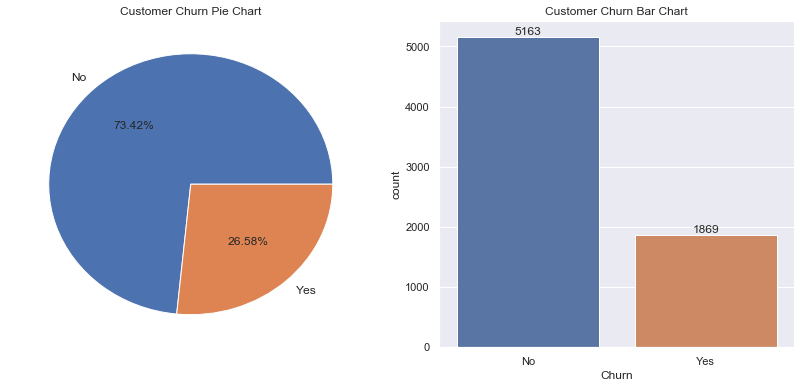

In [17]:
# Pie Chart showing percentages
plt.figure(figsize=(14,6))
plt.subplot(121)
df_visual["Churn"].value_counts().plot.pie(autopct  = "%.2f%%", fontsize=12)
plt.title("Customer Churn Pie Chart")
plt.ylabel("")

# Bar Chart Raw Number
plt.subplot(122)
ax = sns.countplot(x="Churn", data=df_visual)
for i, j in enumerate(df_visual["Churn"].value_counts().values):
    ax.annotate(str(j), (i, j), ha="center", va="bottom", fontsize=12)

plt.title("Customer Churn Bar Chart")
plt.show()

#### Observation:

In the previous month:
* Customers that left: 1869(26.58%)
* Customers that stayed: 5163(73.42%)

### 4.2 Customer Churn Rate of Categorical Variables

We will observe the Churn Rate in each Categorical Variable. There are a total of 16 Categorical Variables: `Gender`, `Senior Citizen`, `Partner`, `Dependents`, `Phone Service`, `Multiple Lines`, `Internet Service`, `Online service`, `Online backup`, `Device protection`, `Tech support`, `Streaming tv`, `Streaming movies`, `Contract`, `Paperless billing` and `Payment method`.

In [18]:
def barchart(variable):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=variable, y="tenure",hue="Churn", data=df_visual, estimator=lambda x: len(x) / len(df_visual) * 100)
    ax.set(ylabel="Percentage(%)")
    ax.set_title("Churn Rate" + "(" + variable + ")",fontsize = 14)
    for p in ax.patches:
        ax.annotate("%.2f" % p.get_height() + "%", (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=15, xytext=(0, 5),textcoords='offset points')  
    plt.show()

### 4.2.1 Gender

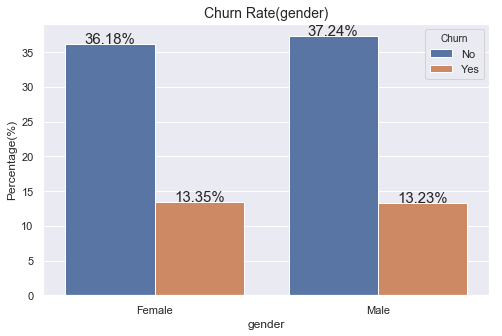

In [19]:
barchart("gender")

#### Observation:
The ratio of churn and no churn in either of the gender groups are very similar. This implies that gender is not a significant feature in determining the output. 


### 4.2.2 Senior Citizen

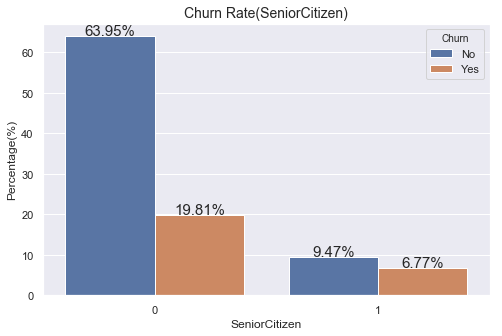

In [20]:
barchart("SeniorCitizen")

#### Observation:
There are more non senior citizens than senior citizens. The churn rate of the non senior citizens are lesser than that of the senior citizens.


### 4.2.3 Partner and Dependents

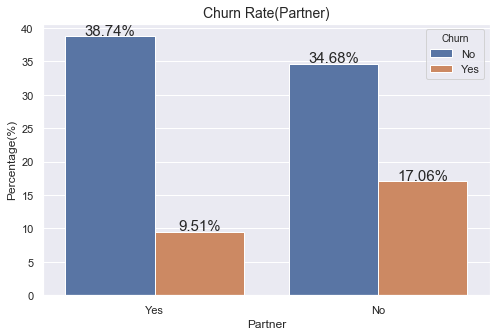

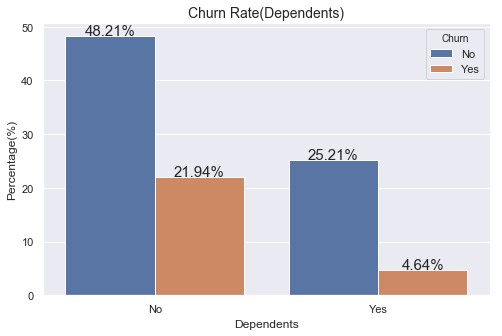

In [21]:
barchart("Partner")
barchart("Dependents")

#### Observation:
- Partner: Customers with no partner has a higher churn rate.
- Dependents: Customers with no dependents have a higher churn rate.


### 4.2.4 Phone Service/Multiple Lines

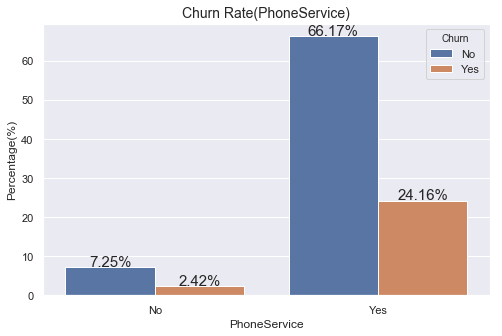

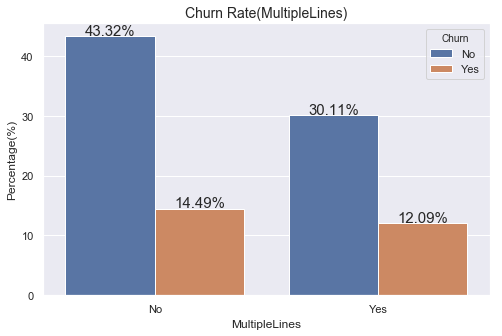

In [22]:
barchart("PhoneService")
barchart("MultipleLines")

#### Observation:
- PhoneService: There are significantly more customers with phone service. Howeover, the ratio of churn and no churn in either of the phoneservice groups are very similar. This implies that PhoneService is not a significant feature in determining the churn rate.

- Multiple Lines: There are more customers without multiplelines. Customers with multiplelines have a higher churn rate. 


### 4.2.5 Internet Service

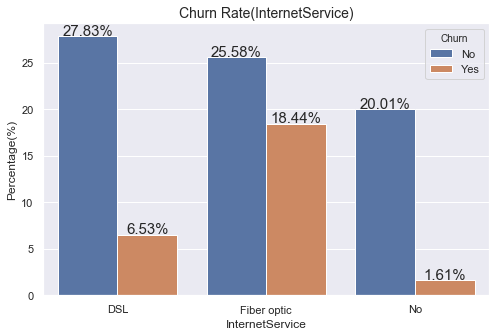

In [23]:
barchart("InternetService")

#### Observation:
Large percentange of customers have fiber optic internet service, followed bby DSL and no internet service. Customers with Fiber optic has the highest churn rate. This implies that the telco has either bad fiber optic service or very expensive fiber optic service. 

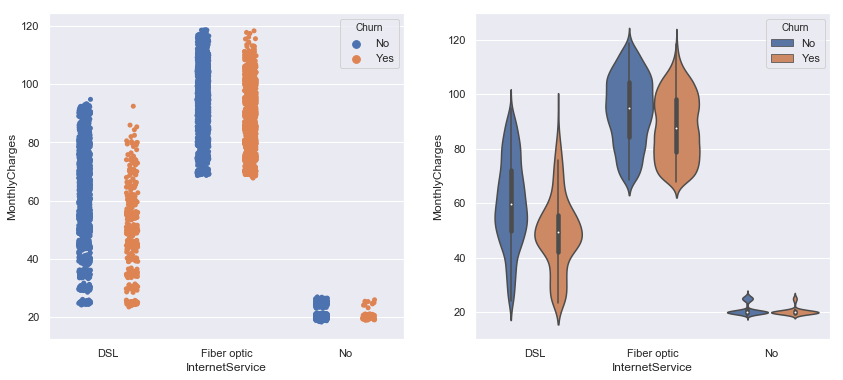

In [24]:
plt.figure(figsize=(14,6))
    
plt.subplot(121)
sns.stripplot(x="InternetService",y="MonthlyCharges",data=df_visual,jitter=True,hue="Churn",dodge=True)

plt.subplot(122)
sns.violinplot(x="InternetService",y="MonthlyCharges",data=df_visual,hue="Churn")

plt.show()

#### Observation:
From the strip plot and violin plot we can observe that there seems to be a correlation between monthly charges and the type of internet service. It is shown that Fiber optics have the highest monthly charges, followed by DSL and no internet service. This is because fiber optics provide a much faster internet connection as compared to DSL. The high monthly charges placed on fiber optics could have been a possible reason for the high churn rate for fiber optics amongst the other types of internet service. 

### 4.2.6 Telco Services
- Online Security
- Online Backup
- Device Protection
- Tech Support
- Streaming TV
- Streaming Movies

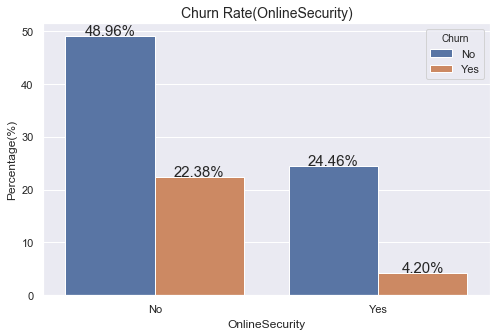

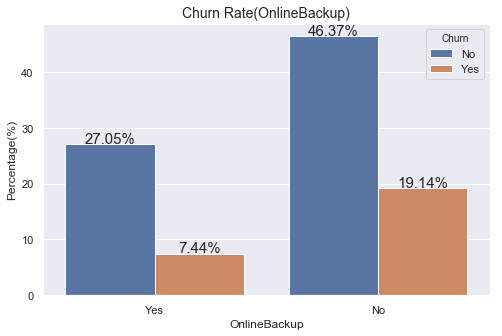

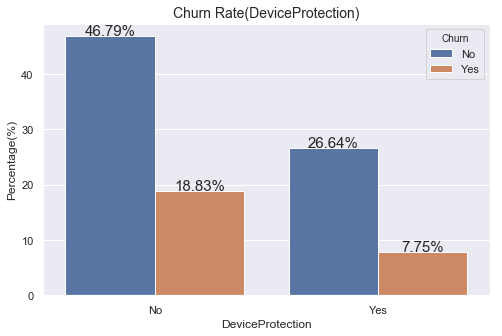

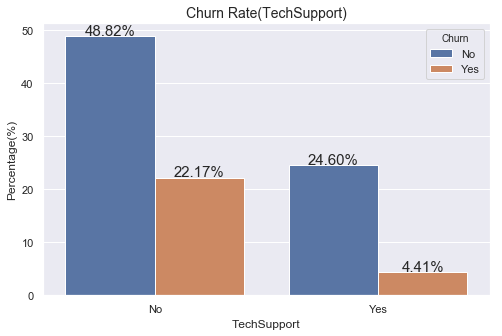

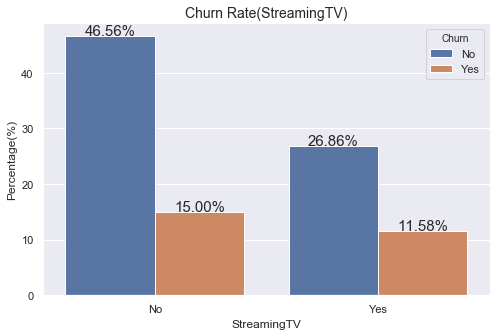

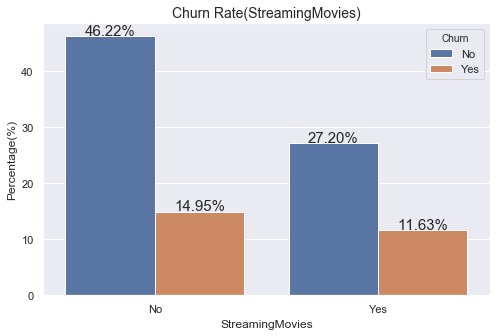

In [25]:
barchart("OnlineSecurity")
barchart("OnlineBackup")
barchart("DeviceProtection")
barchart("TechSupport")
barchart("StreamingTV")
barchart("StreamingMovies")

#### General Observation:
1. Online Security: Customers with online security has a lower churn rate.
2. Online Backup: Customers with online backup has a lower churn rate.
3. Device Protection: Customers with device protection has a lower churn rate.
4. Tech Support: Customers with tech support has a lower churn rate.
5. Streaming TV: Customers with streaming TV has a higher churn rate.
6. Streaming Movies: Customers with streaming Movies has a higher churn rate.


Generally, customers with internet services and device protection has lower churn rate, while those with streaming services has higher churn rate. This could be due to the fact that the streaming services are either bad or more costly.

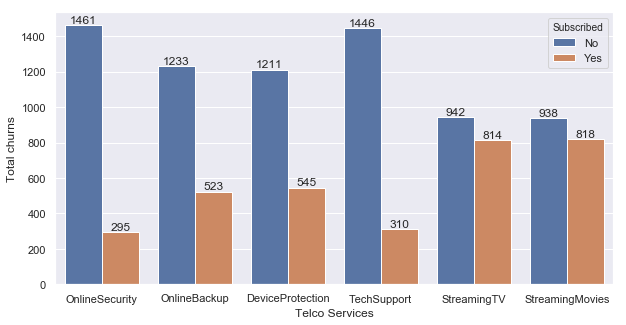

In [26]:
service_set = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
plt.figure(figsize=(10,5))
churn_plot = df_visual[(df_visual['InternetService'] != "No") & (df_visual['Churn'] == "Yes")]
churn_plot = pd.melt(churn_plot[service_set]).rename({'value':'Subscribed'}, axis=1)
ax = sns.countplot(x='variable', hue='Subscribed',data=churn_plot, hue_order=['No', 'Yes'])
ax.set(xlabel='Telco Services', ylabel='Total churns')
for p in ax.patches:
        ax.annotate("%.f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', fontsize=12, xytext=(0, 5),textcoords='offset points')  
plt.show()

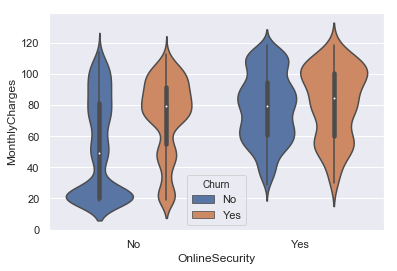

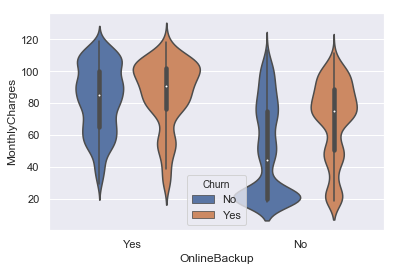

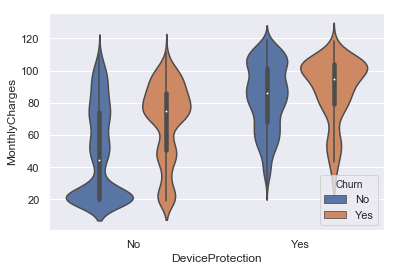

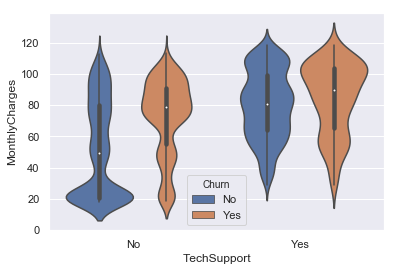

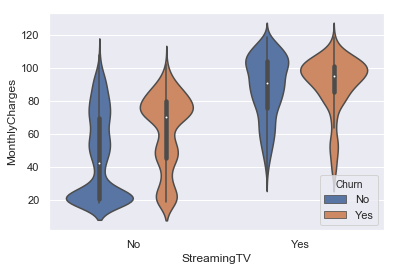

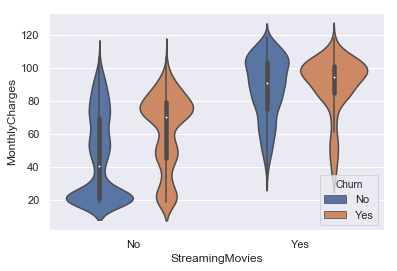

In [27]:
for i in service_set:
    sns.violinplot(x=i,y="MonthlyCharges",data=df_visual,hue="Churn")
    plt.show()

#### Observation:
Generally, telco services have higher monthly charges, and higher monthly charges have higher churn rate. 

### 4.2.7 Contract

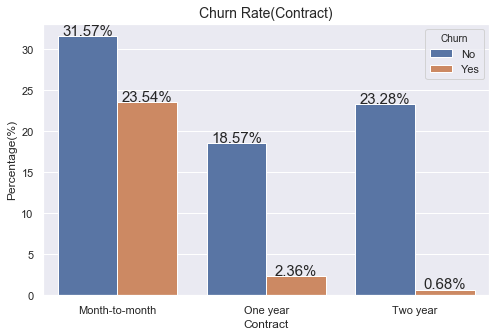

In [28]:
barchart("Contract")


#### Observation:
From the bar chart, customers with Month-to-Month contract tend to have the highest churn rate, followed by one year contract and two year contract. 

### 4.2.8 Paperless Billing and Payment Method

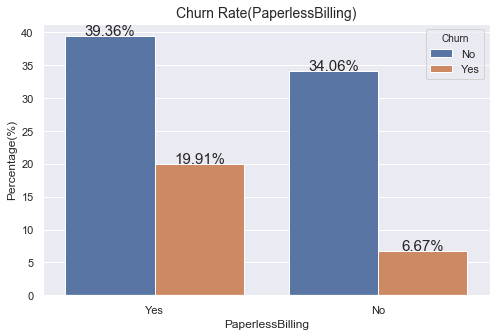

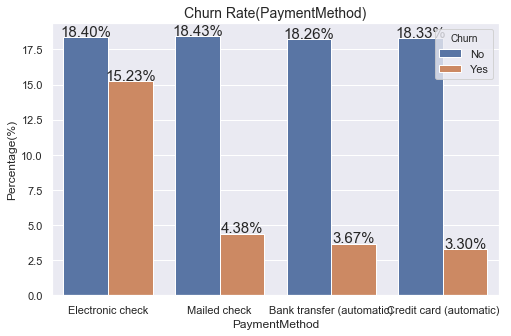

In [29]:
barchart("PaperlessBilling")
barchart("PaymentMethod")

#### Observation:
- Paperless Billing: Customers with papersbilling tend to have higher churn rate.

- Payment Method: Customers with electronic check has the highest churn rate.

### 4.3 Customer Churn Rate of Numerical Variables
In this section, we shall observe the relationship between churn rate and the numerical features. The numerical features are: `MonthlyCharges`, `TotalCharges` and `tenure`. 


MONTHLYCHARGES:


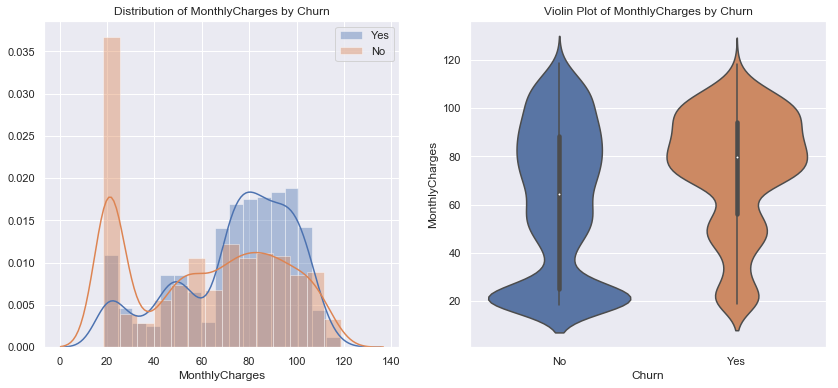

 
TOTALCHARGES:


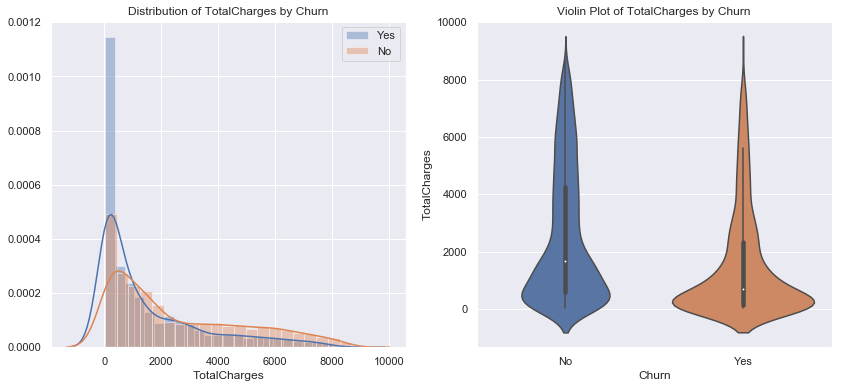

 
TENURE:


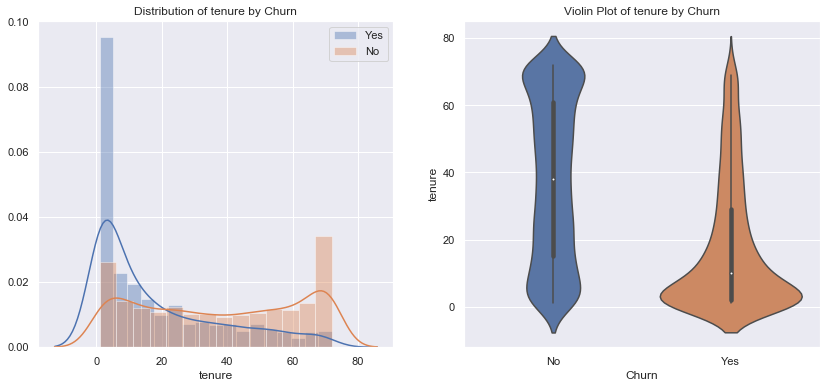

In [30]:
for col_name in num_cols:
    
    plt.figure(figsize=(14,6))
    
    plt.subplot(121)
    print('\033[1m' + col_name.upper() + ":" + '\033[0m')
    ax1 = sns.distplot(df_visual[df_visual["Churn"] == "Yes"][col_name],label = "Yes")
    ax2 = sns.distplot(df_visual[df_visual["Churn"] == "No"][col_name],label = "No")
    plt.title("Distribution of {} by Churn".format(col_name))
    plt.legend()
    
    plt.subplot(122)
    sns.violinplot(x="Churn", y=col_name, data=df_visual)
    plt.title("Violin Plot of {} by Churn".format(col_name))
    
    plt.show()
    print(" ")

#### Observations:
From the above violin plots, we can observe that:
1. MonthlyCharges: Churn is high when monthly charges is high and churn is low when monthly charges are low. This implies that MonthlyCharges is positively correlated to Churn. This is because low prices tend to attract more customers, while high prices deter customers from continuing the same telco. 

2. TotalCharges: There are too many customers when TotalCharges is less than 2000. There is not enough information to infer the correlation between TotalCharges and Churn Rate from the violin plot itself.

3. Tenure: Churn is high when the tenure is low. This is probably due to the fact that the customers may still be deciding on their preferrred telco. It is only after pass the 20-months barrier that the churning rate will decrease and customers will stay loyal to one telco. 

From the above distribution plots, we can observe that:
1. Monthly Charges: Customers with higher monthly charges have a higher churn rate. 

2. Total Charges: Customers with lower total charges have a higher churn rate. 

3. Tenure: Customers with smaller tenure have a higher churn rate or higher risk of churning.

### 4.4 Customer Churn in Tenure Groups

In [31]:
# Customer Churn in Tenure Groups
tenure_churn  =  df_visual[df_visual["Churn"]=="Yes"]["tenure_bins"].value_counts().reset_index()
tenure_churn.columns  = ["tenure_bins","count"]
tenure_no_churn =  df_visual[df_visual["Churn"]=="No"]["tenure_bins"].value_counts().reset_index()
tenure_no_churn.columns = ["tenure_bins","count"]

# bar - churn
trace1 = go.Bar(x = tenure_churn["tenure_bins"]  , y = tenure_churn["count"],
                name = "Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

# bar - not churn
trace2 = go.Bar(x = tenure_no_churn["tenure_bins"] , y = tenure_no_churn["count"],
                name = "Non Churn Customers",
                marker = dict(line = dict(width = .5,color = "black")),
                opacity = .9)

layout = go.Layout(dict(title = "Customer Churn by Tenure Groups",
                        plot_bgcolor  = "rgb(243,243,243)",paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "Tenure Bins",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',title = "count",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                       )
                  )
data = [trace1,trace2]
fig  = go.Figure(data=data,layout=layout)
py.iplot(fig)

#### Observation:
For Customers that have stayed with the teleco for a year, the proportion of churn and non-churn customers is close to a 1:1 ratio. However, beyond the 1 year benchmark, the proportion is more skewed towards the churn customers as there are significantly more churn customers than non-churn customers.

This implies that customers who have stayed with telco for more than a year tend to stay rooted and loyal to the same telco.

### 4.5 Correlation between Numerical Variables 

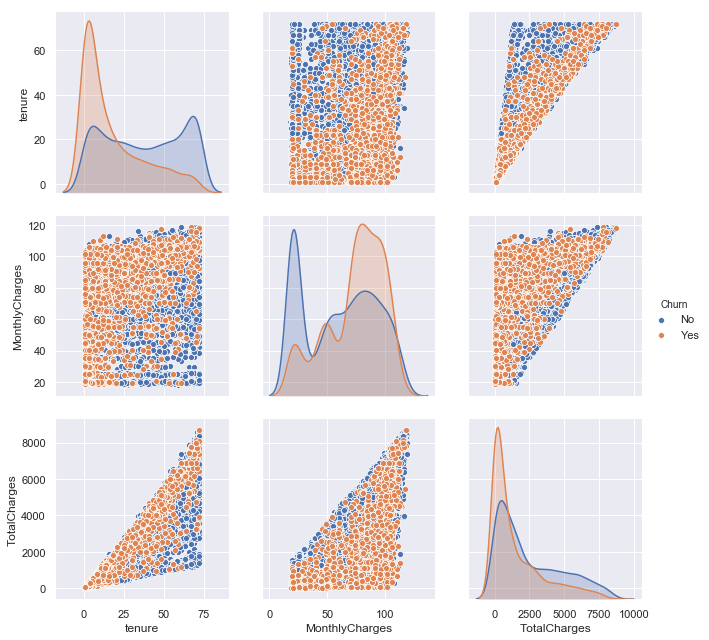

In [32]:
plt.figure(figsize=(18,12))
numerical_features = ['tenure','MonthlyCharges','TotalCharges','Churn']
sns.pairplot(df_visual[numerical_features],hue="Churn",height=3)
plt.show()

#### Observation:
There seems to be a strong correlation between monthly charges and total charges as well as between tenure and total charges. We will support this correlation with a statistical correlation matrix plotted in the heatmap below.

In [33]:
# Construct a correlation matrix
cor_matrix = df_visual[num_cols].corr()
cor_array  = np.array(cor_matrix)
cor_var = num_cols
data = [go.Heatmap(z=cor_array,x=cor_var,y=cor_var,colorscale='Viridis')]
layout = go.Layout(
    autosize=False,
    width=850,
    height=800,
    margin=go.layout.Margin(
        l=200,
        r=0,
        b=200,
        t=20,
        pad=4
    ),
        yaxis = dict(tickfont = dict(size = 10)),
        xaxis = dict(tickfont = dict(size = 10))
)

fig = go.Figure(data,layout)
py.iplot(fig)

#### Observation:
From the above correlation matrix, we can see that `TotalCharges` and `Tenure` have the strongest positive linear relationship as the R^2 value is the highest at 0.8259. Additionally, `TotalCharges` and `MonthlyCharges` have a rather strong positive correlation with the R^2 value of 0.6511. As `TotalCharges` is strong correlated with `Tenure` and `MonthlyCharges`, we may consider removing `TotalCharges` during the Feature Selection process in the model-building. 

### 4.6 How all numerical variables affect customer churn together

In [34]:
trace1 = go.Scatter3d(x = df_visual[df_visual["Churn"]=="Yes"]["MonthlyCharges"],
                      y = df_visual[df_visual["Churn"]=="Yes"]["TotalCharges"],
                      z = df_visual[df_visual["Churn"]=="Yes"]["tenure"],
                      mode = "markers",
                      name = "Churn customers",
                      text = "Id : " + df_visual[df_visual["Churn"]=="Yes"]["customerID"],
                      marker = dict(size = 1,color = "red")
                     )
trace2 = go.Scatter3d(x = df_visual[df_visual["Churn"]=="No"]["MonthlyCharges"],
                      y = df_visual[df_visual["Churn"]=="No"]["TotalCharges"],
                      z = df_visual[df_visual["Churn"]=="No"]["tenure"],
                      mode = "markers",
                      name = "Non churn customers",
                      text = "Id : " + df_visual[df_visual["Churn"]=="No"]["customerID"],
                      marker = dict(size = 1,color= "green")
                     )



layout = go.Layout(dict(title = "Monthly Charges, Total Charges & Tenure against Customer Churn",
                        scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                   center=dict(x=0, y=0, z=0),
                                                   eye=dict(x=1.25, y=1.25, z=1.25)),
                                     xaxis  = dict(title = "monthly charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'),
                                     yaxis  = dict(title = "total charges",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  ),
                                     zaxis  = dict(title = "tenure",
                                                   gridcolor='rgb(255, 255, 255)',
                                                   zerolinecolor='rgb(255, 255, 255)',
                                                   showbackground=True,
                                                   backgroundcolor='rgb(230, 230,230)'
                                                  )
                                    ),
                        height = 700,
                       )
                  )
                  

data = [trace1,trace2]
fig  = go.Figure(data = data,layout = layout)
py.iplot(fig)

### 4.7 Displaying Multivariate Data (Binary Features) by Churn Group

In [35]:
# separating binary columns
bi_cs = df.nunique()[df.nunique() == 2].keys()
dat_rad = df[bi_cs]

# plotting radar chart for churn and non churn customers(binary variables)
def plot_radar(df,aggregate,title) :
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns  = ["feature","yes"]
    data_frame_x["no"]    = data_frame.shape[0]  - data_frame_x["yes"]
    data_frame_x  = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's(yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5),
                            )
    #count of 0's(No)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill  = "toself",name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,linewidth = 2,
                                                           tickwidth = 2,gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor  = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title,height = 700))
    
    data = [trace2,trace1]
    fig = go.Figure(data=data,layout=layout)
    py.iplot(fig)

# plot
plot_radar(dat_rad,1,"Churn -  Customers")
plot_radar(dat_rad,0,"Non Churn - Customers")

### 4.8 Summary of Numerical Features

In [36]:
summary = (df_original[[i for i in num_cols]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#33FFF4']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["#C9C9C9",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Numerical Variables Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

## 5. Machine Learning
- 5.1 Feature Selection
- 5.2 Confusion Matrix and ROC Function
- 5.3 Feature Importance or Coefficient Function
- 5.4 kFold Cross Validation Function 
- 5.5 Cross Validation with SMOTE pipeline Function
- 5.6 Models


### 5.1 Feature Selection
Feature selection is done by using the chi2 scoring function. We will evaluate the significance of each feature at the 5% significance level. The importance of feature selection is to reduce model overfitting and only select the relevant features.

In [37]:
#select columns
cols = [i for i in df_original.columns if i not in ["customerID", "Churn"]]

#dataframe with non negative values
df_x = df_original[cols]
df_y = df_original[output]

#fit model with k= all
select = SelectKBest(score_func = chi2,k = 5)
fit    = select.fit(df_x,df_y)

#create dataframe
score = pd.DataFrame({"features":cols,"scores":fit.scores_,"p_values":fit.pvalues_ })
score = score.sort_values(by = "scores" ,ascending =False)


#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols),"Numerical","Categorical")

#plot
trace  = go.Scatter(x = score[score["feature_type"] == "Categorical"]["features"],
                    y = score[score["feature_type"] == "Categorical"]["scores"],
                    name = "Categorial",mode = "lines+markers",
                    marker = dict(color = "red",line = dict(width =1))
                   )

trace1 = go.Bar(x = score[score["feature_type"] == "Numerical"]["features"],
                y = score[score["feature_type"] == "Numerical"]["scores"],name = "Numerical",
                marker = dict(color = "royalblue",line = dict(width =1)),
                xaxis = "x2",yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor  = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90,zerolinewidth=1,
                                     ticklen=5,gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1,ticklen=5,gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1],tickangle = 90,
                                    gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2',gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data=[trace,trace1]
fig = go.Figure(data=data,layout=layout)
py.iplot(fig)

print("P-value of Insignificant Features")
for index,row in score.iterrows():
    if row[2] > 0.05:
        print(row[0],":",row[2])

score

P-value of Insignificant Features
gender : 0.6140655052865054
PhoneService : 0.7604618273699781


,features,scores,p_values,feature_type
15,TotalCharges,629630.810349,0.000000e+00,Numerical
4,tenure,16377.328093,0.000000e+00,Numerical
14,MonthlyCharges,3653.074681,0.000000e+00,Numerical
19,Contract_Month-to-month,516.714004,2.195119e-114,Categorical
21,Contract_Two year,486.223101,9.454286e-108,Categorical
24,PaymentMethod_Electronic check,424.113152,3.105849e-94,Categorical
17,InternetService_Fiber optic,372.082851,6.587130e-83,Categorical
18,InternetService_No,285.475152,4.814000e-64,Categorical
20,Contract_One year,176.608724,2.666317e-40,Categorical
7,OnlineSecurity,147.165601,7.219883e-34,Categorical


#### Observation:
At the 5% significance level, we can see that `gender` and `phoneservice` are insignificant features that can be removed from the model.

### 5.2 Confusion Matrix and ROC Function
This function evaluates the model by generating the confusion matrix and ROC graph

In [38]:
def cm_and_roc(confusion_matrix, class_names, model, X_test, y_test, figsize = (15,5), fontsize=12):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    # Confusion Matrix
    plt.subplot(121)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix")
    
    # ROC 
    plt.subplot(122)
    
    # Get predicted scores Pr(y=1): Used as thresholds for calculating TP Rate and FP Rate
    score = model.predict_proba(X_test)[:, 1]

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, score) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.title('Receiver operating characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

### 5.3 Feature Importance or Coefficient Function
This function serves to visualise the weight that is assigned to each feature by the model.

In [39]:
def features_importance_or_coef(model, features, model_name):
    
    title_name = "Coefficients"
    
    if model_name == "SVM":
        coefficients = pd.DataFrame(model.coef_.ravel())
    
    elif model_name == "Logistic Regression":
        coefficients = pd.DataFrame(model.coef_[0])
    
    else:
        coefficients  = pd.DataFrame(model.feature_importances_)
        title_name = "Importances"

    column_df     = pd.DataFrame(features)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)

    #plot coeffs
    trace = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                   name = "coefficients",
                   marker = dict(color = coef_sumry["coefficients"],
                                 colorscale = "Picnic",
                                 line = dict(width = .6,color = "black")
                                )
                  )

    layout = go.Layout(autosize = True, 
                       title = "Features {}".format(title_name),
                       plot_bgcolor= 'rgba(240,240,240, 0.95)',
                       paper_bgcolor = 'rgba(240,240,240, 0.95)',
                       margin = dict(b=195)
        
    )
    
    fig = go.Figure(data=[trace],layout=layout)
    fig["layout"]["xaxis"].update(dict(showgrid=True, tickfont=dict(size=10), tickangle=90))
    py.iplot(fig)
    
        
    return 

### 5.4 kFold Cross Validation Function
This function serves to evaluate the model by 10-fold cross validation. The score obtained is the mean accuracy of the multiple folds.

In [40]:
# Create a n-fold cross validation
kf = KFold(n_splits=10, shuffle=True, random_state=12345)

def k_fold_cross_validation(kf, model, feature_matrix, output_vector):
    
    # Conduct n-fold cross validation
    cv_model = cross_val_score(model, # Cross-validation on model
                               feature_matrix, 
                               output_vector,
                               cv=kf, # Cross-validation technique
                               scoring='accuracy',
                               n_jobs=-1
    )
    
    return cv_model

### 5.5 Cross Validation with SMOTE Pipeline Function
This function is a modification of the cross validation that enables only the training set in each fold to undergo Oversampling (SMOTE) to address the unbalanced training set in each fold. This is to ensure that there is no information lekage from the validation set to training set in each fold. 

In [41]:
# Cross Validation with SMOTE pipeline
def cross_validation(kf, X_train, y_train, classifier, seed_num=12345):
    
    np.random.seed(seed_num)
    
    accuracy = []
    recall = []
    precision = []
    f1 = []
    roc_auc = []

    for train, test in kf.split(X_train, y_train):
        
        pipeline = make_pipeline_imb(SMOTE(), classifier)
        model = pipeline.fit(X_train[train], y_train[train])
        prediction = model.predict(X_train[test])

        accuracy.append(pipeline.score(X_train[test], y_train[test]))
        precision.append(precision_score(y_train[test], prediction))
        recall.append(recall_score(y_train[test], prediction))
        f1.append(f1_score(y_train[test], prediction))
        roc_auc.append(roc_auc_score(y_train[test], prediction))
    
    result = {}
    result["accuracy"] = accuracy
    result["recall_score"] = recall
    result["precision"] = precision
    result["f1_score"] = f1
    result["roc_auc_score"] = roc_auc
    
    return result

### 5.6 Models
- Decision Tree
- Ensemble Methods
- Logistic Regression
- KNN Classifier
- Support Vector Machine Classifier

### 5.6.1 Decision Tree

#### Prepare dataset with selected features

In [42]:
# Shift the Churn Column to the back
churn = df["Churn"]
df.drop("Churn", inplace=True, axis=1)
df = df.join(churn)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,7590-VHVEG,0,0,1,0,0.000000,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,1,0,0,0,0.464789,1,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,1,0,0,0,0.014085,1,0,1,1,...,0,0,1,0,0,0,0,0,1,1
3,7795-CFOCW,1,0,0,0,0.619718,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,0,0,0,0,0.014085,1,0,0,0,...,1,0,1,0,0,0,0,1,0,1


In [43]:
# create a copy of df specifically for decision tree
df_decision_tree = deepcopy(df)

# select top 5 features (3 Categorical Features and all 2 Numerical Features)
top_features  = score[score["feature_type"] == "Categorical"]["features"][:3].tolist()
top_features.extend(["MonthlyCharges", "tenure"])
top_features

['Contract_Month-to-month',
 'Contract_Two year',
 'PaymentMethod_Electronic check',
 'MonthlyCharges',
 'tenure']

#### Train Test Split

In [44]:
# Split dataset to do validation: 70% for model fit, 30% for validation
X = df_decision_tree[top_features]
y = df_decision_tree["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [45]:
# Merge X_train and y_train to obtain the training set
training_set = X_train.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")
training_set["Churn"].value_counts() # Unbalanced Training Set

0    3614
1    1308
Name: Churn, dtype: int64

#### Address the Unbalanced Training Set By Oversampling (SMOTE)

In [46]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Train Decision Tree Model

In [47]:
decision_tree = DecisionTreeClassifier(criterion="entropy", random_state=12345)
decision_tree.fit(sm_X_train, sm_y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=12345, splitter='best')

In [48]:
# Get predicted labels for test data
y_pred = decision_tree.predict(X_test)

#### Evaluation of Decision Tree Model
- Confusion Matrix, AUC
- Cross-Validation

In [49]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1179  370]
 [ 254  307]]
1179 370 254 307


In [50]:
# Store all the models metrics in a dictionary
models_metrics = {}

# Performance of decision tree model
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

models_metrics["Decision Tree"] = pd.DataFrame({"Model"           : ["Decision Tree"],
                                                "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                                "Recall_score"    : [recall_score(y_test, y_pred)],
                                                "Precision"       : [precision_score(y_test, y_pred)],
                                                "f1_score"        : [f1_score(y_test, y_pred)],
                                                "ROC_AUC_Score"   : [roc_auc_score(y_test, y_pred)]
                                               })


Accuracy:  0.704265402843602
Recall Score:  0.5472370766488414
Precision:  0.4534711964549483
f1 Score:  0.49596122778675283
ROC_AUC_Score: 0.6541866467814899


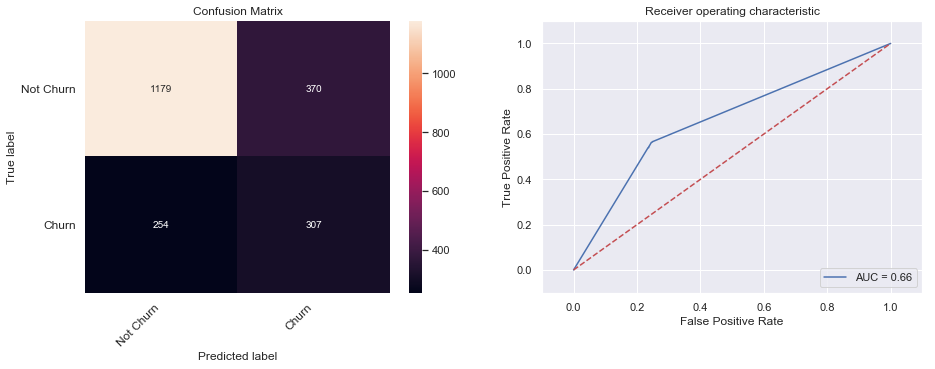

In [51]:
cm_and_roc(cm, ['Not Churn','Churn'], decision_tree, X_test, y_test)
features_importance_or_coef(decision_tree, top_features, "Decision Tree")

In [52]:
results = cross_validation(kf, X_train.values, y_train.values, DecisionTreeClassifier(criterion="entropy", random_state=12345))

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.

In [53]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.7092683751381124
recall_score: 0.5634218876391099
precision: 0.46109700509682633
f1_score: 0.5068416003154954
roc_auc_score: 0.6625544297984256


### 5.6.2 Ensemble Methods
1. Bootstrap Aggregating (Bagging)
2. Random Forest
3. Boosting

### 5.6.2.1 Bootstrap Aggregating (Bagging)

#### Prepare the dataset with selected features

In [54]:
df_bagging = deepcopy(df)

In [55]:
# select top 5 features
top_features

['Contract_Month-to-month',
 'Contract_Two year',
 'PaymentMethod_Electronic check',
 'MonthlyCharges',
 'tenure']

#### Train Test Split

In [56]:
# Split dataset to do validation: 70% for model fit, 30% for validation
X = df_bagging[top_features]
y = df_bagging["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [57]:
# Merge X_train and y_train to obtain the training set
training_set = X_train.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")

training_set["Churn"].value_counts() # Unbalanced Training Set

0    3614
1    1308
Name: Churn, dtype: int64

#### Address the Unbalanced Training Set By Oversampling (SMOTE)

In [58]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Train the Bagging Model

In [59]:
bagging = BaggingClassifier(n_estimators=100, random_state=12345)
bagging.fit(sm_X_train, sm_y_train)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=100, n_jobs=None, oob_score=False,
         random_state=12345, verbose=0, warm_start=False)

In [60]:
# Get predicted labels for test data
y_pred = bagging.predict(X_test)

#### Evaluation of Bagging Model
- Confusion Matrix, AUC
- Cross Validation

In [61]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1195  354]
 [ 230  331]]
1195 354 230 331


In [62]:
# Performance of Bagging model
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

models_metrics["Bagging"] = pd.DataFrame({"Model"           : ["Bagging"],
                                          "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                          "Recall_score"    : [recall_score(y_test, y_pred)],
                                          "Precision"       : [precision_score(y_test, y_pred)],
                                          "f1_score"        : [f1_score(y_test, y_pred)],
                                          "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                         })

Accuracy:  0.7232227488151659
Recall Score:  0.5900178253119429
Precision:  0.4832116788321168
f1 Score:  0.5313001605136436
ROC_AUC_Score: 0.6807416434500321


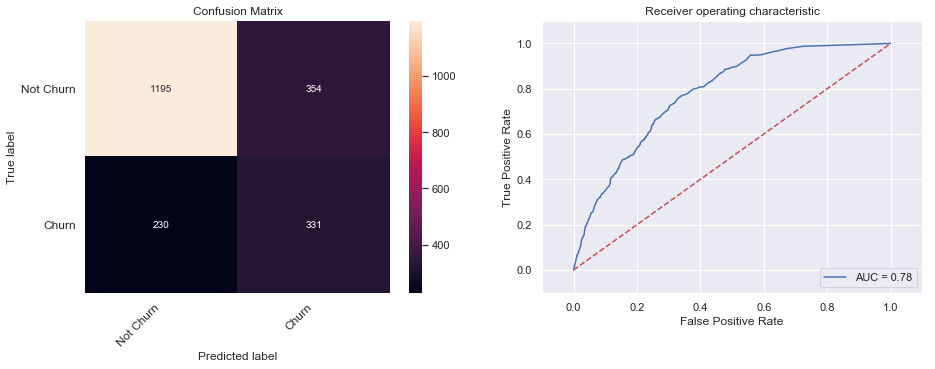

In [63]:
cm_and_roc(cm, ['Not Churn','Churn'], bagging, X_test, y_test)

In [64]:
results = cross_validation(kf, X_train.values, y_train.values,
                           BaggingClassifier(n_estimators=100, random_state=12345)
                           )

print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.

Cross Validation Results
accuracy: 0.738520589059846
recall_score: 0.5921602502724397
precision: 0.506077557304965
f1_score: 0.5449108924686644
roc_auc_score: 0.6917739556816141


### 5.6.2.2 Random Forest

#### Prepare the dataset with selected features

In [65]:
df_random_forest = deepcopy(df)

In [66]:
# Drop gender, phone service and Total Charges
df_random_forest.drop(["PhoneService", "TotalCharges", "gender"], axis=1, inplace=True)

#### Train Test Split

In [67]:
# Split dataset to do validation: 70% for model fit, 30% for validation
features = [x for x in df_random_forest if x not in ["customerID", "Churn"]]
X = df_random_forest[features]
y = df_random_forest["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [68]:
# Merge X_train and y_train to obtain the training set
training_set = X_train.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")

In [69]:
training_set["Churn"].value_counts() # Unbalanced Training Set

0    3614
1    1308
Name: Churn, dtype: int64

#### Address the Unbalanced Training Set By Oversampling (SMOTE)

In [70]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Train Random Forest Model

In [71]:
random_forest = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=12345)
random_forest.fit(sm_X_train, sm_y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=12345, verbose=0,
            warm_start=False)

In [72]:
y_pred = random_forest.predict(X_test)

#### Evaluation of Random Forest Model
- Confusion Matrix, AUC
- Cross-Validation

In [73]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1311  238]
 [ 230  331]]
1311 238 230 331


In [74]:
# Performance of random forest model
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

models_metrics["Random Forest"] = pd.DataFrame({"Model"           : ["Random Forest"],
                                                "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                                "Recall_score"    : [recall_score(y_test, y_pred)],
                                                "Precision"       : [precision_score(y_test, y_pred)],
                                                "f1_score"        : [f1_score(y_test, y_pred)],
                                                "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                               })



Accuracy:  0.7781990521327015
Recall Score:  0.5900178253119429
Precision:  0.5817223198594025
f1 Score:  0.5858407079646017
ROC_AUC_Score: 0.7181851553932213


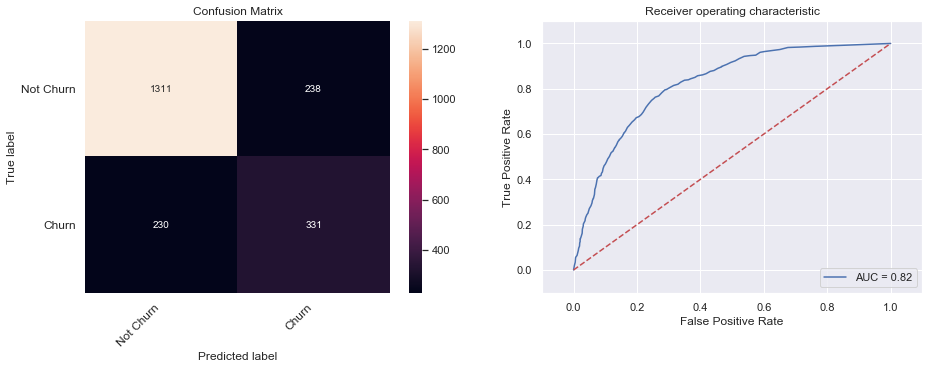

In [75]:
cm_and_roc(cm, ['Not Churn','Churn'], random_forest, X_test, y_test)
features_importance_or_coef(random_forest, features, "Random Forest")

In [76]:
results = cross_validation(kf, X_train.values, y_train.values, 
                           RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=12345)
                          )

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.

In [77]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))

Cross Validation Results
accuracy: 0.768189613944821
recall_score: 0.5544753363103622
precision: 0.5646933092712031
f1_score: 0.5586981689686328
roc_auc_score: 0.7000265922877266


### 5.6.2.3 AdaBoost

#### Prepare the dataset with selected features

In [78]:
df_adaboost = deepcopy(df)

In [79]:
# Drop gender, phone service and Total Charges
df_adaboost.drop(["PhoneService", "TotalCharges", "gender"], axis=1, inplace=True)

In [80]:
# Split dataset to do validation: 70% for model fit, 30% for test
X = df_adaboost[[x for x in df_adaboost.columns if x not in ["customerID", "Churn"]]]
y = df_adaboost["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [81]:
# Merge X_train and y_train to obtain the training set
training_set = X_train.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")

training_set["Churn"].value_counts() # Unbalanced Training Set

0    3614
1    1308
Name: Churn, dtype: int64

#### Address the Unbalanced Training Set By Oversampling (SMOTE)

In [82]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())


#### Train the Adaboost Model

In [83]:
Adaboost = AdaBoostClassifier(n_estimators=100, random_state=12345)
Adaboost.fit(sm_X_train, sm_y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=12345)

In [84]:
# get predicted output
y_pred = Adaboost.predict(X_test)

#### Evaluation of Adaboost
- Confusion Matrix, AUC
- Cross Validation

In [85]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1225  324]
 [ 154  407]]
1225 324 154 407


In [86]:
new_models_metrics = {}

# Performance of Adaboost
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

models_metrics["Adaboost"] = pd.DataFrame({"Model"           : ["Adaboost"],
                                           "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                           "Recall_score"    : [recall_score(y_test, y_pred)],
                                           "Precision"       : [precision_score(y_test, y_pred)],
                                           "f1_score"        : [f1_score(y_test, y_pred)],
                                           "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                          })
new_models_metrics["Adaboost"] = pd.DataFrame({"Model"           : ["Adaboost"],
                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                      "Recall_score"    : [recall_score(y_test, y_pred)],
                                      "Precision"       : [precision_score(y_test, y_pred)],
                                      "f1_score"        : [f1_score(y_test, y_pred)],
                                      "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                     })

Accuracy:  0.7734597156398104
Recall Score:  0.7254901960784313
Precision:  0.5567715458276333
f1 Score:  0.6300309597523219
ROC_AUC_Score: 0.7581614957151357


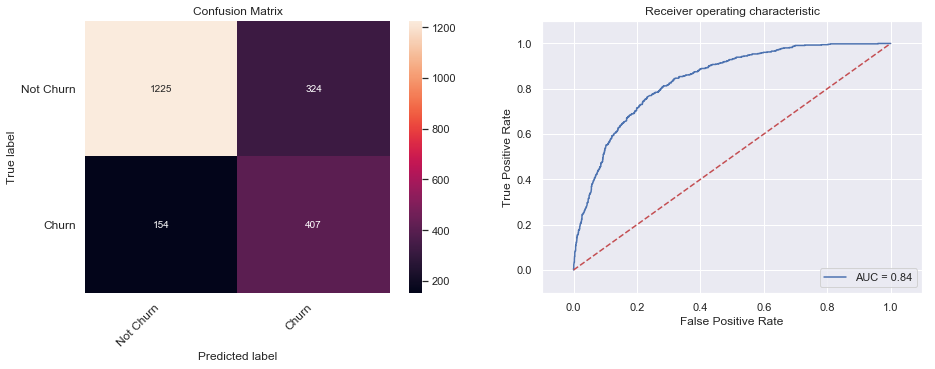

In [87]:
cm_and_roc(cm, ['Not Churn','Churn'], Adaboost, X_test, y_test)
features = [x for x in df_adaboost.columns if x not in ["customerID", "Churn"]]
features_importance_or_coef(Adaboost, features, "Adaboost")


In [88]:
results = cross_validation(kf, X_train.values, y_train.values, 
                           AdaBoostClassifier(n_estimators=100, random_state=12345))

print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.

Cross Validation Results
accuracy: 0.7720464552515708
recall_score: 0.7276199970449848
precision: 0.5536921983645329
f1_score: 0.6284325783597174
roc_auc_score: 0.7577752446748731


### 5.6.3 Logistic Regression 


#### Prepare the dataset with selected features

In [89]:
df_lr = deepcopy(df)

In [90]:
# Drop gender and phoneservice as their p-value is greater than 0.05 at the 5% significance level
# Drop TotalCharges as it has high collinearity
df_lr.drop(["gender", "PhoneService", "TotalCharges"], axis=1, inplace=True)

In [91]:
# Split dataset to do validation: 70% for model fit, 30% for test
X = df_lr[[x for x in df_lr.columns if x not in ["customerID", "Churn"]]]
y = df_lr["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [92]:
# Merge X_train and y_train to obtain the training set
training_set = X_train.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")

In [93]:
training_set["Churn"].value_counts() # Unbalanced Training Set

0    3614
1    1308
Name: Churn, dtype: int64

#### Address the Unbalanced Training Set By Oversampling (SMOTE)

In [94]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Train the Logistic Regression Model

In [95]:
# lr 1: Logistic regression with L1 regularization
lr_1 = LogisticRegression(fit_intercept=True, max_iter=1000, tol=2e-9, penalty='l1', C=100, random_state=12345)

# lr 2: Logistic regression with L2 regularization
lr_2 = LogisticRegression(fit_intercept=True, max_iter=1000, tol=2e-9, penalty='l2', C=100, random_state=12345)

In [96]:
lr_1.fit(sm_X_train, sm_y_train)
lr_2.fit(sm_X_train, sm_y_train)

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=12345, solver='warn',
          tol=2e-09, verbose=0, warm_start=False)

In [97]:
y_pred_lr1 = lr_1.predict(X_test)
y_pred_lr2 = lr_2.predict(X_test)

#### Evalutaion of Logistic Regression 
- Confusion Matrix, AUC
- Cross-Validation

In [98]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_lr1)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1155  394]
 [ 116  445]]
1155 394 116 445


In [99]:
# Performance of Logistic Regression with L1
print ("Accuracy: ", accuracy_score(y_test, y_pred_lr1))
print ("Recall Score: ", recall_score(y_test, y_pred_lr1))
print ("Precision: ", precision_score(y_test, y_pred_lr1))
print ("f1 Score: ", f1_score(y_test, y_pred_lr1))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lr1))

models_metrics["Logistic Regression"] = pd.DataFrame({"Model"           : ["Logistic Regression"],
                                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred_lr1)],
                                                      "Recall_score"    : [recall_score(y_test, y_pred_lr1)],
                                                      "Precision"       : [precision_score(y_test, y_pred_lr1)],
                                                      "f1_score"        : [f1_score(y_test, y_pred_lr1)],
                                                      "ROC_AUC_Score"   : [roc_auc_score(y_test, y_pred_lr1)]
                                                     })

new_models_metrics["Logistic Regression"] = pd.DataFrame({"Model"           : ["Logistic Regression"],
                                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred_lr1)],
                                                      "Recall_score"    : [recall_score(y_test, y_pred_lr1)],
                                                      "Precision"       : [precision_score(y_test, y_pred_lr1)],
                                                      "f1_score"        : [f1_score(y_test, y_pred_lr1)],
                                                      "ROC_AUC_Score"   : [roc_auc_score(y_test, y_pred_lr1)]
                                                     })


Accuracy:  0.7582938388625592
Recall Score:  0.7932263814616756
Precision:  0.5303933253873659
f1 Score:  0.6357142857142858
ROC_AUC_Score: 0.7694343656824194


In [100]:
# Performance of Logistic Regression with L2
print ("Accuracy: ", accuracy_score(y_test, y_pred_lr2))
print ("Recall Score: ", recall_score(y_test, y_pred_lr2))
print ("Precision: ", precision_score(y_test, y_pred_lr2))
print ("f1 Score: ", f1_score(y_test, y_pred_lr2))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lr2))


Accuracy:  0.7582938388625592
Recall Score:  0.7932263814616756
Precision:  0.5303933253873659
f1 Score:  0.6357142857142858
ROC_AUC_Score: 0.7694343656824194


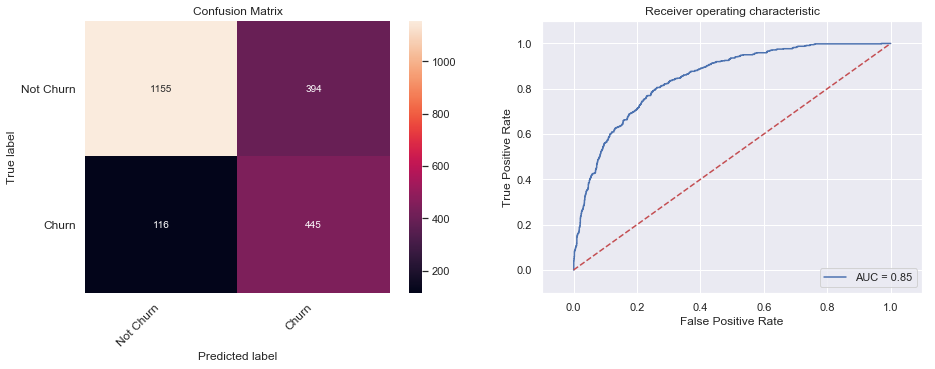

In [101]:
cm_and_roc(cm, ['Not Churn','Churn'], lr_1, X_test, y_test)
features = [x for x in df_lr.columns if x not in ["customerID", "Churn"]]
features_importance_or_coef(lr_1, features, "Logistic Regression")

In [102]:
results = cross_validation(kf, X_train.values, y_train.values,
                           LogisticRegression(fit_intercept=True, max_iter=1000, tol=2e-9, penalty='l1', C=100, random_state=12345)
                          )


/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packa

In [103]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.7464478306040666
recall_score: 0.7738967392082221
precision: 0.5147009830515994
f1_score: 0.6177962676380482
roc_auc_score: 0.7550966998094047


In [104]:
## Note: TotalCharges - a highly correlated feature wont affect the logistic regression performance 
# but affect the interpretation of the coefficient

### 5.6.4 KNN Classifier

#### Prepare dataset with selected features

In [105]:
df_knn = deepcopy(df)

In [106]:
df_knn.drop(["PhoneService", "gender", "TotalCharges"], axis=1, inplace=True)

In [107]:
# Split dataset to do validation: 70% for model fit, 30% for test
X = df_knn[[x for x in df_knn.columns if x not in ["customerID", "Churn"]]]
y = df_knn["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [108]:
# Merge X_train and y_train to obtain the training set
training_set = X_train.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")

In [109]:
training_set["Churn"].value_counts() # Unbalanced Training Set

0    3614
1    1308
Name: Churn, dtype: int64

#### Address the Unbalanced Training Set By Oversampling (SMOTE)

In [110]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Train the KNN Model

In [111]:
knn = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn.fit(X=sm_X_train, y=sm_y_train)

# get predicted output
y_pred = knn.predict(X_test)

#### Evaluation of KNN Model
- Confusion Matrix, AUC
- Cross-Validation

In [112]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1074  475]
 [ 143  418]]
1074 475 143 418


In [113]:
# Performance of KNN Classifier
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

models_metrics["KNN Classifier"] = pd.DataFrame({"Model"           : ["KNN Classifier"],
                                                 "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                                 "Recall_score"    : [recall_score(y_test, y_pred)],
                                                 "Precision"       : [precision_score(y_test, y_pred)],
                                                 "f1_score"        : [f1_score(y_test, y_pred)],
                                                 "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                                })


Accuracy:  0.7071090047393365
Recall Score:  0.7450980392156863
Precision:  0.46808510638297873
f1 Score:  0.5749656121045392
ROC_AUC_Score: 0.7192242939784049


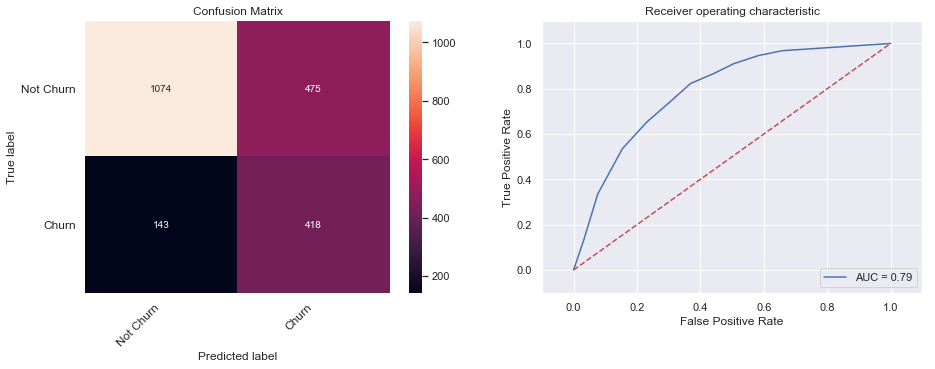

In [114]:
cm_and_roc(cm, ['Not Churn','Churn'], knn, X_test, y_test)

In [115]:
results = cross_validation(kf, X_train.values, y_train.values, 
                           KNeighborsClassifier(n_neighbors=10, weights='uniform'))

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.

In [116]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))

Cross Validation Results
accuracy: 0.7157777997658273
recall_score: 0.7355318498048513
precision: 0.4773922467769228
f1_score: 0.5785288288975045
roc_auc_score: 0.7220646041413306


### 5.6.5 Support Vector Machine

#### Prepare dataset with selected features

In [117]:
df_svm = deepcopy(df)

In [118]:
df_svm.drop(["PhoneService", "gender", "TotalCharges"], axis=1, inplace=True)

In [119]:
# Split dataset to do validation: 70% for model fit, 30% for test
X = df_svm[[x for x in df_svm.columns if x not in ["customerID", "Churn"]]]
y = df_svm["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

In [120]:
# Merge X_train and y_train to obtain the training set
training_set = X_train.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")

In [121]:
training_set["Churn"].value_counts() # Unbalanced Training Set

0    3614
1    1308
Name: Churn, dtype: int64

#### Address the Unbalanced Training Set By Oversampling (SMOTE)

In [122]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Train the SVM Model

In [123]:
svc_lin  = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
               max_iter=-1, probability=True, random_state=12345, shrinking=True,
               tol=0.001, verbose=False)
svc_lin.fit(sm_X_train, sm_y_train)

# get predicted output
y_pred = svc_lin.predict(X_test)
probabilities = svc_lin.predict_proba(X_test)

#### Evaluation of SVM model
- Confusion matrix, AUC
- Cross Validation

In [124]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[1104  445]
 [ 103  458]]
1104 445 103 458


In [125]:
# Performance of SVC 
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

models_metrics["SVC"] = pd.DataFrame({"Model"           : ["SVC"],
                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                      "Recall_score"    : [recall_score(y_test, y_pred)],
                                      "Precision"       : [precision_score(y_test, y_pred)],
                                      "f1_score"        : [f1_score(y_test, y_pred)],
                                      "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                     })

new_models_metrics["SVC"] = pd.DataFrame({"Model"           : ["SVC"],
                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                      "Recall_score"    : [recall_score(y_test, y_pred)],
                                      "Precision"       : [precision_score(y_test, y_pred)],
                                      "f1_score"        : [f1_score(y_test, y_pred)],
                                      "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                     })

Accuracy:  0.7402843601895734
Recall Score:  0.8163992869875223
Precision:  0.5071982281284607
f1 Score:  0.6256830601092896
ROC_AUC_Score: 0.7645585847461821


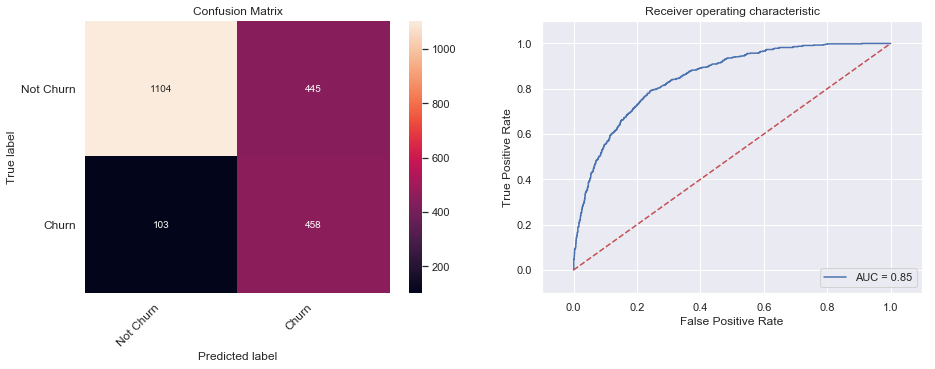

In [126]:
cm_and_roc(cm, ['Not Churn','Churn'], svc_lin, X_test, y_test)
features = [x for x in df_svm.columns if x not in ["customerID", "Churn"]]
features_importance_or_coef(svc_lin, features, "SVM")

In [127]:
results = cross_validation(kf, X_train.values, y_train.values,
                           SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                               decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
                               max_iter=-1, probability=True, random_state=12345, shrinking=True,
                               tol=0.001, verbose=False
                              )
                           )

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.

In [128]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.7186171440821914
recall_score: 0.8033024394455911
precision: 0.4831548115200407
f1_score: 0.6026875042371364
roc_auc_score: 0.7455793918007497


## 6. Comparing the Models

### 6.1 Overall Baseline Accuracy
- Blanket Assign `No Churn` to the dataset since `No Churn` has the majority vote

In [129]:
result = df["Churn"].value_counts()
probability = result.max()/df["Churn"].size
print("Baseline Accuracy:", probability)

Baseline Accuracy: 0.7342150170648464


### 6.2 Summary of all the Models Scores

In [130]:
model_performances = pd.concat(list(models_metrics.values()),axis = 0).reset_index()
model_performances = model_performances.drop(columns = "index",axis =1)


table  = ff.create_table(np.round(model_performances,4))

py.iplot(table)

#### Observation:
Adaboost, Logistic Regression and SVC all have relatively high accuracy and recall scores. 
With the baseline accuracy set at 0.7342, any models that have accuracy below 0.7342 can be evaluated as poor model since it did not improve the baseline accuracy that has zero predictive power. Decision Tree, Bagging and KNN Classifier are all models with accuracy below the baseline accuracy.

### 6.3 Visualisation of the Models Scores

In [131]:
model_visual = deepcopy(model_performances)

In [132]:
model_visual = pd.melt(model_visual,id_vars="Model", var_name="Metrics", value_name="Score")

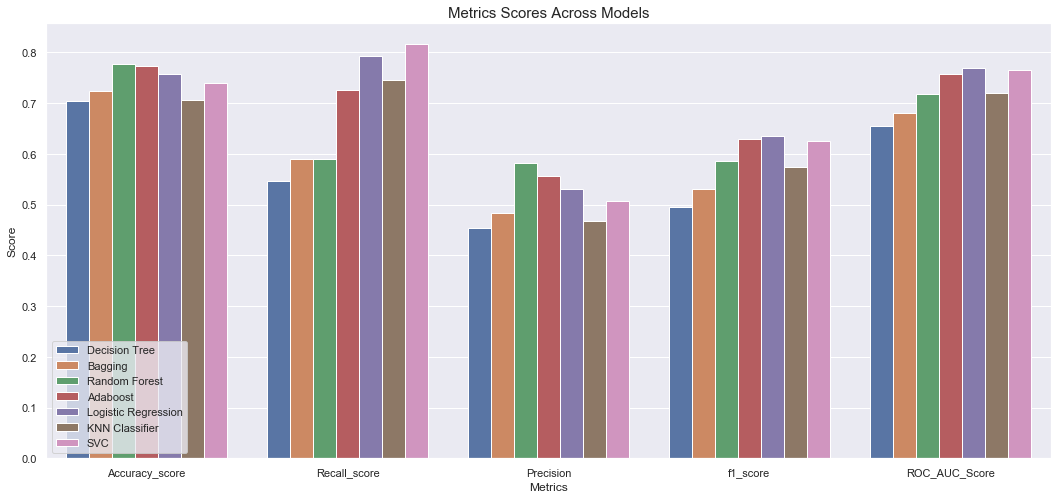

In [133]:
plt.figure(figsize=(18,8))
ax = sns.barplot(x='Metrics', y='Score',hue="Model", data=model_visual)
plt.title("Metrics Scores Across Models",fontsize=15)
plt.legend(loc='lower left')
plt.show()

### 7. Hyper-Parameters Optimisation of the Best Model
Accuracy and sensitivity are performance metrics used to rank the models. By the accuracy paradox, accuracy alone can be a misleading measure. Sensitivity (recall_score) and precision, however are less ambiguous. In the case of a telco, it is desirable to have high sensitivity (focus on the group of customers that have a higher propensity to churn) at the expense of precision since failing to recognize these customers leads to a greater loss for their company.

From the above results, we can see that `Logistic Regression`, `Adaboosting` and `SVC` has relatively high accuracy and sensitivity. As such, we will select these 2 models as our best models, and proceed to fine tune their parameters to further enhance their prediction performance. 

### 7.1 Logistic Regression with GridSearchCV

In [134]:
# Initialise the model with default parameters
logistic_regression = LogisticRegression(fit_intercept=True, max_iter=1000, tol=2e-9, random_state=12345)


#### Prepare the dataset

In [135]:
df_lr = deepcopy(df)
# Drop gender and phoneservice as their p-value is greater than 0.05 at the 5% significance level
df_lr.drop(["gender", "PhoneService", "TotalCharges"], axis=1, inplace=True)

#### Train Test Split

In [136]:
# Split dataset to do validation: 70% for model fit, 30% for test
X = df_lr[[x for x in df_lr.columns if x not in ["customerID", "Churn"]]]
y = df_lr["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

#### Address the Unbalanced Training Set by Oversampling (SMOTE)

In [137]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Determine Hyperparameters

In [138]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(classification__C=C, classification__penalty=penalty)

#### Grid Search using 5-fold cross validation
- a pipeline is created to SMOTE the training set during the cross-validation at every iteration rather than before cross-validation to prevent overfitting

In [139]:
pipeline = Pipeline([
    ('sampling', SMOTE(random_state=12345)),
    ('classification', logistic_regression)
])

best_model = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, scoring="recall")
best_model.fit(X_train, y_train)



/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=12345, ratio='auto', svm_estimator=None)), ('classification', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=12345, solver='warn',
          tol=2e-09, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classification__C': array([1.00000e+00, 2.78256e+00, 7.74264e+00, 2.15443e+01, 5.99484e+01,
       1.66810e+02, 4.64159e+02, 1.29155e+03, 3.59381e+03, 1.00000e+04]), 'classification__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [140]:
print(best_model.best_score_)
print(best_model.best_params_)
print(best_model.best_estimator_)

0.773699132336759
{'classification__C': 7.742636826811269, 'classification__penalty': 'l1'}
Pipeline(memory=None,
     steps=[('sampling', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=12345, ratio='auto', svm_estimator=None)), ('classification', LogisticRegression(C=7.742636826811269, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='warn', n_jobs=None, penalty='l1',
          random_state=12345, solver='warn', tol=2e-09, verbose=0,
          warm_start=False))])


#### Redefine the model with the new hyperparameters

In [141]:
lr_final = LogisticRegression(C =7.742636826811269, penalty = "l1", 
                              fit_intercept=True, max_iter=1000, tol=2e-9, random_state=12345)
lr_final.fit(sm_X_train, sm_y_train)
y_pred = lr_final.predict(X_test)

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



#### Evaluate the model performance

In [142]:
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

new_models_metrics["Logistic Regression (GridSearchCV)"] = pd.DataFrame({"Model"           : ["Logistic Regression (GridSearchCV)"],
                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                      "Recall_score"    : [recall_score(y_test, y_pred)],
                                      "Precision"       : [precision_score(y_test, y_pred)],
                                      "f1_score"        : [f1_score(y_test, y_pred)],
                                      "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                     })


Accuracy:  0.7587677725118483
Recall Score:  0.7932263814616756
Precision:  0.5310262529832935
f1 Score:  0.636168691922802
ROC_AUC_Score: 0.7697571545784815


### 7.2 Support Vector Machine with GridSearchCV

In [143]:
# Initialise the model with default parameters
svc = SVC(cache_size=200, class_weight=None, coef0=0.0,
          decision_function_shape='ovr', degree=3,
          max_iter=-1, probability=True, random_state=12345, shrinking=True,
          tol=0.001, verbose=False)

#### Prepare the dataset

In [144]:
df_svm = deepcopy(df)
df_svm.drop(["PhoneService", "gender", "TotalCharges"], axis=1, inplace=True)


#### Train Test Split

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

#### Address the Unbalanced Training Set by Oversampling (SMOTE)

In [146]:
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Determine Hyperparameters

In [147]:
# Create regularization hyperparameter space
C = [0.001, 0.01, 0.1, 1, 10]

# Create gammas space
gamma = [0.001, 0.01, 0.1, 1]

# Create kernel space
kernel = ["linear", "rbf"]

# Create hyperparameter options
hyperparameters = dict(classification__C=C, classification__gamma=gamma, classification__kernel=kernel)

#### Grid Search using 5-fold cross validation
- a pipeline is created to SMOTE the training set during the cross-validation at every iteration rather than before cross-validation to prevent overfitting

In [148]:
pipeline = Pipeline([
    ('sampling', SMOTE(random_state=12345)),
    ('classification', svc)
])


best_model = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, scoring="recall")
best_model.fit(X_train, y_train)

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the execu

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=12345, ratio='auto', svm_estimator=None)), ('classification', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=12345,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classification__C': [0.001, 0.01, 0.1, 1, 10], 'classification__gamma': [0.001, 0.01, 0.1, 1], 'classification__kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [149]:
print(best_model.best_score_)
print(best_model.best_params_)
print(best_model.best_estimator_)

0.8868481029039118
{'classification__C': 0.001, 'classification__gamma': 0.001, 'classification__kernel': 'rbf'}
Pipeline(memory=None,
     steps=[('sampling', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=12345, ratio='auto', svm_estimator=None)), ('classification', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=12345, shrinking=True,
  tol=0.001, verbose=False))])


#### Redefine the model with the new hyperparameters

In [150]:
svc_final = SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=True, random_state=12345, shrinking=True,
  tol=0.001, verbose=False)

svc_final.fit(sm_X_train, sm_y_train)
y_pred = svc_final.predict(X_test)

#### Evaluate the new model performance

In [151]:
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

new_models_metrics["SVC (GridSearchCV)"] = pd.DataFrame({"Model"           : ["SVC (GridSearchCV)"],
                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                      "Recall_score"    : [recall_score(y_test, y_pred)],
                                      "Precision"       : [precision_score(y_test, y_pred)],
                                      "f1_score"        : [f1_score(y_test, y_pred)],
                                      "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                     })


Accuracy:  0.6578199052132702
Recall Score:  0.8948306595365418
Precision:  0.4309012875536481
f1 Score:  0.5816917728852838
ROC_AUC_Score: 0.7334062916791811


### 7.3 Adaboosting with GridSearchCV

In [152]:
# Initialise the model with default parameters
Adaboost = AdaBoostClassifier(random_state=12345)

#### Prepare the dataset

In [153]:
df_adaboost = deepcopy(df)
# Drop gender, phone service and Total Charges
df_adaboost.drop(["PhoneService", "TotalCharges", "gender"], axis=1, inplace=True)

#### Train Test Split

In [154]:
# Split dataset to do validation: 70% for model fit, 30% for test
X = df_adaboost[[x for x in df_adaboost.columns if x not in ["customerID", "Churn"]]]
y = df_adaboost["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345, stratify=y)

#### Address the Unbalanced Training Set by Oversampling (SMOTE)

In [155]:
sm = SMOTE(random_state=12345)
sm_X_train, sm_y_train = sm.fit_sample(X_train, y_train.ravel())

#### Determine Hyperparameters

In [156]:
# Create learning_rate space
learning_rate = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]

# Create n_estimators space
n_estimators = [300,400,500,600,700]

# Create hyperparameter options
hyperparameters = dict(classification__learning_rate=learning_rate, classification__n_estimators=n_estimators)

#### Grid Search using 5-fold cross validation
- a pipeline is created to SMOTE the training set during the cross-validation at every iteration rather than before cross-validation to prevent overfitting

In [157]:
pipeline = Pipeline([
    ('sampling', SMOTE(random_state=12345)),
    ('classification', Adaboost)
])


best_model = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, scoring="recall")
best_model.fit(X_train, y_train)



/Users/zhengjiesung/anaconda3/lib/python3.6/site-packages/imblearn/pipeline.py:190: DeprecationWarning:

The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.



GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('sampling', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=12345, ratio='auto', svm_estimator=None)), ('classification', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=12345))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'classification__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'classification__n_estimators': [300, 400, 500, 600, 700]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=0)

In [158]:
print(best_model.best_score_)
print(best_model.best_params_)
print(best_model.best_estimator_)

0.7775118082917116
{'classification__learning_rate': 0.1, 'classification__n_estimators': 300}
Pipeline(memory=None,
     steps=[('sampling', SMOTE(k=None, k_neighbors=5, kind='regular', m=None, m_neighbors=10, n_jobs=1,
   out_step=0.5, random_state=12345, ratio='auto', svm_estimator=None)), ('classification', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=300, random_state=12345))])


#### Redefine the model with the new hyperparameters

In [159]:
Adaboost_final = AdaBoostClassifier(algorithm='SAMME.R', 
                                    base_estimator=None,
                                    learning_rate=0.1, 
                                    n_estimators=300, 
                                    random_state=12345)

Adaboost_final.fit(sm_X_train, sm_y_train)
y_pred = Adaboost_final.predict(X_test)

#### Evaluate the new model performance

In [160]:
print ("Accuracy: ", accuracy_score(y_test, y_pred))
print ("Recall Score: ", recall_score(y_test, y_pred))
print ("Precision: ", precision_score(y_test, y_pred))
print ("f1 Score: ", f1_score(y_test, y_pred))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred))

new_models_metrics["Adaboost (GridSearchCV)"] = pd.DataFrame({"Model"           : ["Adaboost (GridSearchCV)"],
                                      "Accuracy_score"  : [accuracy_score(y_test, y_pred)],
                                      "Recall_score"    : [recall_score(y_test, y_pred)],
                                      "Precision"       : [precision_score(y_test, y_pred)],
                                      "f1_score"        : [f1_score(y_test, y_pred)],
                                      "ROC_AUC_Score": [roc_auc_score(y_test, y_pred)]
                                     })


Accuracy:  0.7606635071090048
Recall Score:  0.7985739750445633
Precision:  0.5333333333333333
f1 Score:  0.6395431834403997
ROC_AUC_Score: 0.7727537402659872


### 7.4 Comparison with Previous Models

In [161]:
new_model_performances = pd.concat(list(new_models_metrics.values()),axis = 0).reset_index()
new_model_performances = new_model_performances.drop(columns = "index",axis =1)

new_model_performances

,Model,Accuracy_score,Recall_score,Precision,f1_score,ROC_AUC_Score
0,Adaboost,0.773460,0.725490,0.556772,0.630031,0.758161
1,Logistic Regression,0.758294,0.793226,0.530393,0.635714,0.769434
2,SVC,0.740284,0.816399,0.507198,0.625683,0.764559
3,Logistic Regression (GridSearchCV),0.758768,0.793226,0.531026,0.636169,0.769757
4,SVC (GridSearchCV),0.657820,0.894831,0.430901,0.581692,0.733406
5,Adaboost (GridSearchCV),0.760664,0.798574,0.533333,0.639543,0.772754


#### Observation:
From the results above, we can see that:
1. Logistic Regression with GridSearchCV has a slightly better accuracy and same recall_score as compared to its original model
2. SVC with GridSearchCV has its reacall_score improved significantly at the cost of its accuracy. 
3. Adaboost with GridSearchCV has relatively similar accuracy and higher recall_score as compared to its original model.

Clearly, the finetuning of hyperparameters by GridSearchCV has improved the models recall_score. 

#### Choosing the best model:
Both Adaboost and Logistic Regression with finetuned hyperparameters are evaulated as the best models given their relatively high accuracy and recall scores. To truly determine the best model amongst the 2, we can consider the computational efficiency of each model.